**<center>Hello World Seminar - 3.22.2024</center>**
**<center>_Topic_: Garbled Circuit Implementation and Analysis</center>**
<center>Group: Shenghui Li</center>

   

#### List of notebook requirements:
1. Python 3.10+
    - _structural patter matching_ from 3.10+ (see [whats-new: 3.10+](https://docs.python.org/3/whatsnew/3.10.html#pep-634-structural-pattern-matching))
    - _lcm-function_ requries math-library from 3.9+ (see [whats-new: 3.9+](https://docs.python.org/3/whatsnew/3.9.html#math))
    - _modular multiplicative inverse_ using the pow-function requires math-library from 3.8+ (see [whats-new: 3.8+](https://docs.python.org/3/whatsnew/3.8.html#other-language-changes))
    - _assignment expressions_ from 3.8+ (see [whats-new: 3.8+](https://docs.python.org/3/whatsnew/3.8.html#assignment-expressions))
2. sympy package (primality check) - [Installation instructions](https://docs.sympy.org/latest/install.html)
3. ipywidgets package (interactive notebook) - [Installation instructions](https://ipywidgets.readthedocs.io/en/stable/user_install.html) & [Widget documentation](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html#)
4. pandas (visualization of exeriment results) - [Installation instructions](https://pandas.pydata.org/docs/getting_started/install.html#installing-from-pypi)
5. seaborn (visualization of exeriment results) - [Installation instructions](https://seaborn.pydata.org/installing.html)

#### Notebook usage:
- The notebook is interactive after executing it
- Please ignore all code section when reading this notebook. It is sufficient to look at the figures and read the markdowns.
- The notebook ends with two simulations (each 300 gabled circuits of increasing size, Section 5) which might take about 5 minutes. If you do not want to perform the simulation experiments for time reasons, simply do not execute Section 5 (this section does not contain interactive parts and therefore does not have to be run)

In [4]:
## check that the requirements are satisfied, notify about missing once and raise an exception

# Requirement 1
from platform import python_version
version = list(map(int,python_version().split('.')))
if version[0] < 3 or (version[0] == 3 and version[1] < 10):
    raise Exception('This notebook requires Python 3.10+')
    
# Requirement 2
try:
    from sympy import isprime
except:
    raise Exception('\n -> Please ensure Sympy is installed.\n -> A link to the installation instructions can be found at the beginning of this notebook.')

# Requirement 3
try:
    from ipywidgets import Button
except:
    raise Exception('\n -> Please ensure Jupyter Widgets are installed.\n -> A link to the installation instructions can be found at the beginning of this notebook.')

# Requirement 4
try:
    from pandas import DataFrame
except:
    raise Exception('\n -> Please ensure pandas is installed.\n -> A link to the installation instructions can be found at the beginning of this notebook.')

# Requirement 5
try:
    from seaborn import boxplot
except:
    raise Exception('\n -> Please ensure seaborn is installed.\n -> A link to the installation instructions can be found at the beginning of this notebook.')

## let's use the os.path module such that it should work under both windows and unix
from IPython.display import HTML
import os.path
img1 = os.path.join('img','problem-visualization.png')
img2s = [os.path.join('img',x) for x in ['system-design.png','circuit-design.png','recursive-circuit.png']]
img3s = [os.path.join('img',f'garble-gate-s{x}.png') for x in range(1,7)]


___________________________________________________
## Problem: Set intersection size


## 1. Introduction
### 1.1 Problem description

<center>Consider Alice and Bob both pick a word and would like to </center>
<center><i>compute how many letters their words have in common, without sharing the words or which letters are present.</i></center>

In [5]:
HTML(f'<center><img src="{img1}" width="400"/></center>')

Problem: This settings corresponds to computing the **size of a set intersection using secure multi-party computation**.

### 1.2 Considered threat model
We assume a *semi-honest adversary* (Alice/Bob correctly follow the protocol, but try to violate the others privacy - find out the others word or letters within it).


### 1.2 Method (subject of study)

We would like to **solve this problem using garbled circtuits**.

We restrict the project in the following manner:
- use the classical garbled circuit method of Yao (1986)
- use OT protocol of Even et al. (1985)
- no optimizations (e.g. _free XOR optimization_ would turn out to be very efficient here)
- only using binary gates (only use 1-out-of-2 OT)

### 1.3 Analysis, study questions & goals

We are interested in understanding:
- how many gates does a naive implementation require?
- how many messages have to be exchanged for computing a naive circuit for this problem?
- how does this setting scale with different alphabet sizes?


### Main references/Study material
- _Oblivious transfer:_ S. Even, O. Goldreich, A. Lempel - "A Randomized Protocol for Signing Contracts", Communications of the ACM (1985), pp. 637–647
- _Garbled circuits:_ S. Yakoubov - "A Gentle Introduction to Yao’s Garbled Circuits"

_______________________
## 2. Background and Implementation

### 2.1 Oblivious Transfer (1-out-of-2 bit OT)

There are many protocols for a 1-out-of-2 bit OT. The used version is based on RSA and its description can be found [here](https://en.wikipedia.org/wiki/Oblivious_transfer#1%E2%80%932_oblivious_transfer).

**Setup:**
- Alice has two messages ($m_0$, $m_1$) and the RSA key pair $(e,d,N)$
- Bob has the public key $(e,N)$ and a selection bit $b \in \{0,1\}$ to pick one of the messages $m_b$.

**Protocol:**
1. Alice sends two random numbers ($x_0$, $x_1$) to Bob
2. Bob generates a random number $k$ and sends $v = (x_b + k^e) ~ ~ ~\textrm{mod } N$ to Alice
3. Alice sends to Bob $m_0' = m_0 + ((v - x_0)^d ~ ~\textrm{mod } N)$ and $m_1' = m_1 + ((v - x_1)^d ~ ~ ~\textrm{mod } N)$
4. Bob computes $m_b = m_b'- k$

**How does this work?**<br/>
Let us roll up the computation and assume $b = 0$. For simplicity, we do now write out the modulo in this simple sketch.

\begin{gather}
m_0 =& m_0' - k& \textrm{using step 4}\\ 
m_0 =& m_0 + (v - x_0)^d - k & \textrm{using: } m_0' = m_0 + ((v - x_0)^d ~ ~\textrm{mod } N)\\
m_0 =& m_0 + (x_0 + k^e - x_0)^d - k &  \textrm{using: } v = (x_0 + k^e) ~ ~ ~\textrm{mod } N\\
m_0 =& m_0 + (k^e)^d - k &\\
m_0 =& m_0 + k - k & \textrm{using: } (m^e)^d = m~ ~ ~\textrm{mod } N\\
m_0 =& m_0&
\end{gather}

- Bob encrypts his random number $k$ and adds either $x_0$ or $x_1$ from Alice to obtain $v$
- Alice can now substract her random numbers ($x_0$ or $x_1$) from $v$ and decrypt it to obtain two possibilities for $k$. She does not know which of these two numbers is Bob's $k$, but can use them as random offset for shifting $m_0$ and $m_1$.
- Since Bob knows $b$, he knows for which message he can invert the offset to obtain Alice's message ($k$). Since Bob is unable to decrypt $v$, he cannot find out what the offset for the second message would be.

**Analysis:**<br/>
- each oblivious transfer requires the communication of 5 numbers with 3 transmissions in total
- notice that Bob can only decript one of the two messages and therefore has _no_ access to the second message

In [6]:
# setup RSA
from math import lcm, gcd             # math library comes with python
from sympy import isprime

# RSA parameters
p, q, e = 281,467,641  # pick parameters
assert isprime(p) and isprime(q)     # check that selected p & q are prime
assert e < lcm(p-1,q-1) and gcd(e,lcm(p-1,q-1)) == 1

# key setup
N = p*q
d = pow(e, -1, lcm(p-1,q-1))     # compute modular multiplicative inverse of e
AlicePublicKey = (e,N)
AlicePrivateKey = (e,d,N)
print(f'\nRSA setup:\n\t- Public key:\t(e = {AlicePublicKey[0]}, N = {AlicePublicKey[1]})\
      \n\t- Private key:\t(e = {AlicePrivateKey[0]}, d = {AlicePrivateKey[1]}, N = {AlicePrivateKey[2]})\n')


RSA setup:
	- Public key:	(e = 641, N = 131227)      
	- Private key:	(e = 641, d = 16081, N = 131227)



In [7]:
# perform oblivious transfer and log send messages in a list for later analysis
from random import randint           # random library comes with python

## 1-out-of-2 bit OT ##
# All Oblivious Transfers are send by Alice and Recived by Bob
# m1, m2:      integers mod N
# channel:     list, send messages will be appended, each message has format ('description', [content,...])
# b:           selection bit (0 or 1)
# privateKey:  private key of the sender (Alice)
def ObliviousTransfer(m0,m1,b,channel,privateKey):
    e,d,N = privateKey
    assert b in [0,1]                # assert b valid
    assert m0 < N and m1 < N         # assert m0 % N == m0 and m1 % N == m1 (can be encrypted)
    random = lambda: randint(0,N) # define a random function of arbitrary range
    
    # Step 1: Alice sends two random numbers
    channel.append(('OT A->B s1',[x0 := random(), x1 := random()]))
    
    # step 2: Bob sends v
    xb = x0 if b == 0 else x1
    k = random()
    channel.append(('OT B->A s2',[v := ((xb + k**e) % N)]))
    
    # step 3: Alice sends the shifted messages
    channel.append(('OT A->B s3',[m0s := (m0 + ((v - x0)**d) % N), m1s := (m1 + ((v - x1)**d) % N)]))
    
    # step 4: Bob computes the result
    mbs = m0s if b == 0 else m1s
    mb = (mbs - k) % N
    
    return mb

In [8]:
channel = []
print(ObliviousTransfer(100,150,0,channel,AlicePrivateKey))
print(channel)

100
[('OT A->B s1', [98912, 47075]), ('OT B->A s2', [42115]), ('OT A->B s3', [5903, 35841])]


### 2.2 Problem representation

Let us represent the problem. Consider both parties compute a dictionary about which charcters are present in their own sentence.

In [9]:
# pre-processing of Alice and Bob (word to circuit input dictionary)
from string import ascii_lowercase                   # string library comes with python
alphabet  = list(ascii_lowercase) + [' ']            # let's consider lower case letters and empty spaces
AliceWord = 'red tulip'                              # pick word for Alice
BobWord   = 'yellow tulip'                           # pick word for Bob

assert all([(c in alphabet) for c in AliceWord]) # check that Alice word is within the alphabet 
assert all([(c in alphabet) for c in BobWord])   # check that Bob word is within the alphabet 

AliceInput = [(c, 1 if (c in AliceWord) else 0) for c in alphabet]  # generate Alice circuit input
BobInput   = [(c, 1 if (c in BobWord)   else 0) for c in alphabet]  # generate Bob circuit input

print('Input Name \t Alice Input \t Bob Input')
for x,y in zip(AliceInput,BobInput):
    print(f'     {x[0]}\t\t      {x[1]}\t\t     {y[1]}')

Input Name 	 Alice Input 	 Bob Input
     a		      0		     0
     b		      0		     0
     c		      0		     0
     d		      1		     0
     e		      1		     1
     f		      0		     0
     g		      0		     0
     h		      0		     0
     i		      1		     1
     j		      0		     0
     k		      0		     0
     l		      1		     1
     m		      0		     0
     n		      0		     0
     o		      0		     1
     p		      1		     1
     q		      0		     0
     r		      1		     0
     s		      0		     0
     t		      1		     1
     u		      1		     1
     v		      0		     0
     w		      0		     1
     x		      0		     0
     y		      0		     1
     z		      0		     0
      		      1		     1


We can also write this as simple recursive function to compute the desired output. **Let us implement this recursive version as garbled circuit!**

\begin{gather}
\textrm{IntersectionCount}~[]~[]~n &=& n\\
\textrm{IntersectionCount}~(x :: xs)~(y :: ys)~n &=& \textrm{IntersectionCount}~xs~ys~(n+1~ ~\textrm{ if }~ ~x+y = 2~ ~\textrm{ else }~ ~n)
\end{gather}


In [10]:
# a short version, does not really make the structure clear...
# InputX = [('letter', present), ...]                  <- takes list of tuples
def IntersectionCount_v1(InputA,InputB):
    return sum(map(lambda x: x[0][1] + x[1][1] == 2,  zip(InputA,InputB)))

In [11]:
# simple recursive implemenation, more verbose
def IntersectionCount_v2(xs,ys,n):
    assert len(xs) == len(ys)
    match (xs,ys,n):               # nice to finally have structural patter matching
        case ([],[],n):                    return n
        case ([(_,x),*xs],[(_,y),*ys],n):  return IntersectionCount_v2(xs,ys,(n+1 if x == 1 and y == 1 else n))

In [12]:
print('V1 result: ', IntersectionCount_v1(AliceInput,BobInput))
print('V2 result: ', IntersectionCount_v2(AliceInput,BobInput,0))

V1 result:  7
V2 result:  7


_________________________________________

### 3 Circuit/Protocol Design

#### 3.1 System Design

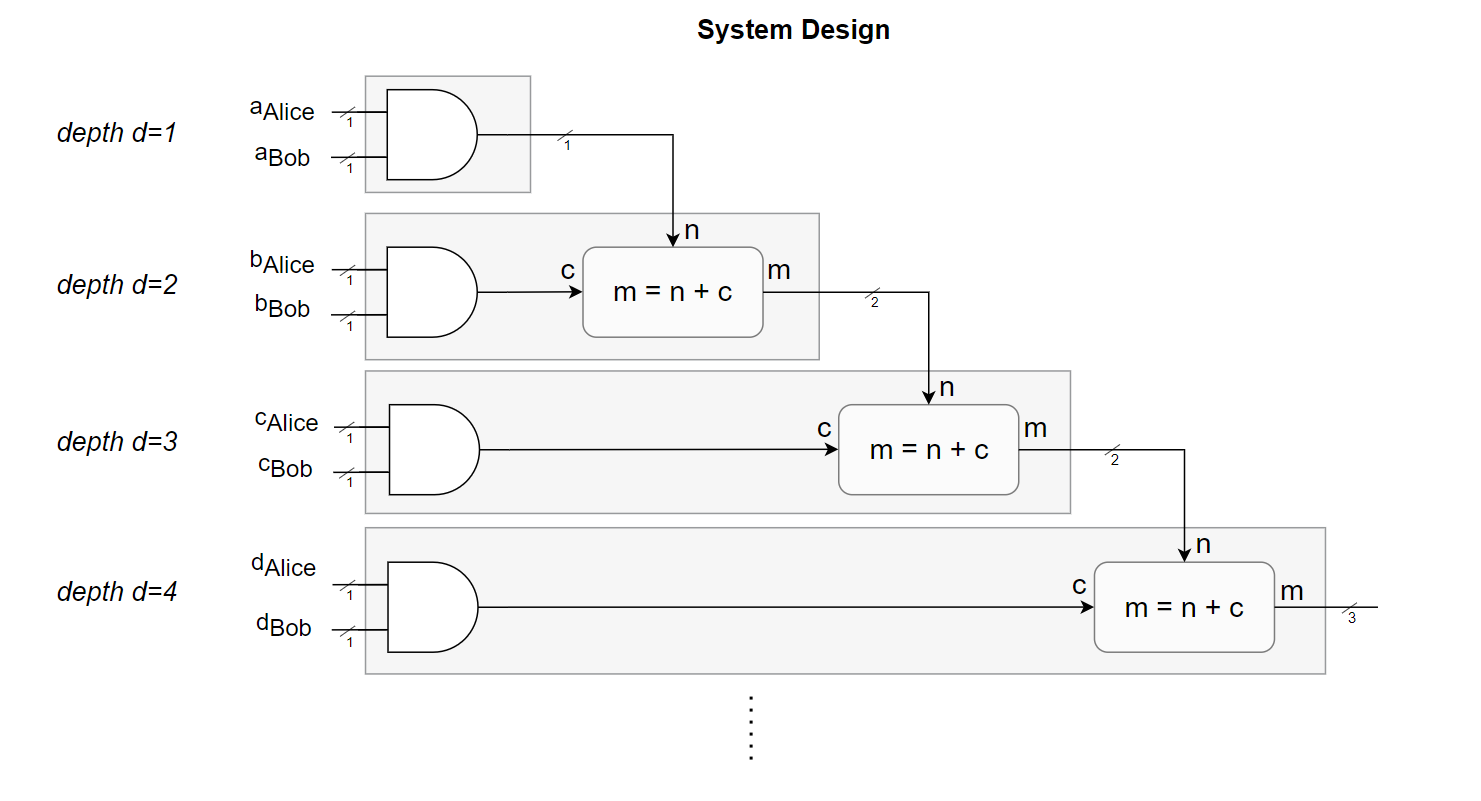

In [13]:
## Generate Figures to vislualize the approach...
from ipywidgets import Button, HBox
from IPython.display import Image, display, clear_output

count_1 = 0
previousImg_1 = Button(description="previous")
nextImg_1 = Button(description="next")
previousImg_1.on_click(lambda _: display_next_1(-1))
nextImg_1.on_click(lambda _: display_next_1(+1))

def display_next_1(i):
    global count_1
    count_1 = (count_1 + i) % len(img2s)
    clear_output(wait=True)
    display(Image(filename=img2s[count_1]))
    
display(HBox([previousImg_1,nextImg_1]))
clear_output(wait=True)
display(Image(filename=img2s[count_1]))

($n_0$/$m_0$ are the least-significant bit, $n_i$/$m_{i+1}$ are the most-significant bit.)

*<center> We need to implement the _'recursive circuit module'_ (last image) with garbled gates to solve the problem</center>*

#### 3.2 Theoretical Analysis

A short theoretical analysis of the system design. Consider $\alpha$ to be the alphabet size:
- we use Alice as gabler and Bob as evaluator
- the protocol is invariant to the length of the string from Alice and Bob but scales with the alphabet size ($\alpha$)

- each input of Bob requires one OT
- each usage of the OT protocol requires a total of 3 messages

- each gate requries one transmission from Alice to Bob (1 message)
- each recursive module contains 1 AND gate for the input and $\lceil \log_2(d) \rceil$ half adders with each 1 AND and 1 XOR gate

#### 3.2.1 Number of transmissions

##### Summary...
- the *number of required gates* based on the alphabet size $\alpha$: 
\begin{equation}
\alpha + 2\cdot \sum_{d=1}^{\alpha} \lceil \log_2(d) \rceil
\end{equation}
- the *number of required OTs* based on the alphabet size $\alpha$: 
\begin{equation}
\alpha
\end{equation}

##### Protocol design
- Alice generates and garbles the full circuit and sends the entire garbled circuit to Bob at once
- Each gate requires the transmission of 4 words + 1 word as trailer information (trailer=What does a valid label end with?) + 1 word for Alice label
- Each OT requires 3 tranmission with a total of 5 words, however, we can perform all OTs simultaneously

#### Protocol analysis
- Circuit transmission:
    - Alice sends the full circuit which is a message of $\alpha + 5\cdot(\alpha + 2\cdot \sum_{d=1}^{\alpha} \lceil \log_2(d) \rceil)$ words 
    - (Alice $\alpha$ input labels and for each gate 5 words (4 encrypted gate output values + 1 trailer)
- OT for Bob's inputs (simultaneouly for all inputs):
    - Alice sends $(x_0,x_1)$ for each input, which is a message of $2 \alpha$ words
    - Bob replies with $v$ for each input, which is a message of $\alpha$ words
    - Alice sends $(m_0',m_1')$ for each input, which is a message of $2 \alpha$ words
- Bob evaluates the circuit:
    - Bob sends the result back to Alice, which is a message of $\lceil \log_2(\alpha +1 ) \rceil$ words
- Alice reveals converts the label results:
    - Alice sends the de-garbled result back to Bob, which is a message of $1$ word
    
The protocol consists of 6 messages between Alice and Bob (if the possible message size was infinite).

The transmitted amount of data would be $1 + 11 \alpha + \lceil \log_2(\alpha+1) \rceil + 10 \cdot \sum_{d=1}^\alpha(\lceil \log_2(d) \rceil)$ words.

*The theoretical results are visulized in more detail below.*

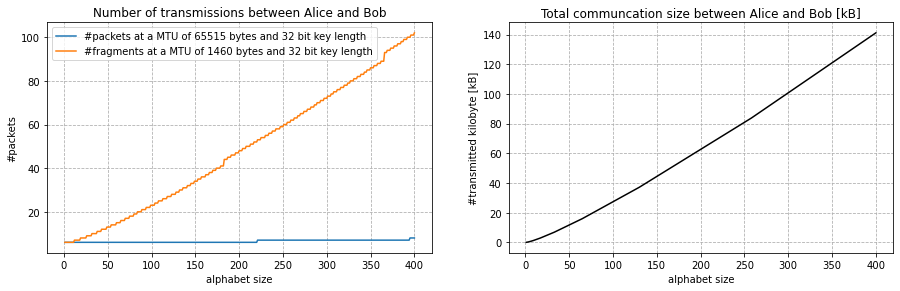


The computation for an alphabet size of 100 at a label/key size of 32 bit requires the transmission of:
	- 6 packets (max. load 65515 byte)
	- 23 fragments (max. load 1460 byte)
	- 27 kByte of total data


In [ ]:
## Let's visualize these theoretical resutls
# plot transmission vs alphabet size
from ipywidgets import IntRangeSlider, Dropdown, IntText, interact
import matplotlib.pyplot as plt
from math import ceil, log
log2 = lambda x: log(x)/log(2) if x != 0 else 0


IP = IntText(value=65515,description='Max. IP load [byte]')
MTU = IntText(value=1460,description='Max. fragment load [byte]')
Label = Dropdown(options=(32,64,128,256,512),value=32,description='Label/Key-length [bit]')
Alphabet = IntRangeSlider(value=[1,401], step=10, min=1, max=1000,description='Alphabet size')
ReadOut = IntText(value=100,description='Read-out for x=')
display(IP)
display(MTU)
display(Label)
display(Alphabet)
display(ReadOut)
    
# compute the message number at each step of the protocol
AliceSendCircuitMessageNumber = lambda alpha,size,keylength: ceil(ceil((alpha + 5*(alpha + 2*sum([ceil(log2(d)) for d in range(1,alpha+1)])))*keylength/8)/size)
AliceSendsXMessageNumber = lambda alpha,size,keylength: ceil(ceil(2*alpha*keylength/8)/size)
BobSendsVMessageNumber = lambda alpha,size,keylength: ceil(ceil(alpha*keylength/8)/size)
AliceSendsMMessageNumber = lambda alpha,size,keylength: ceil(ceil(2*alpha*keylength/8)/size)
BobSendsResultMessageNumber = lambda alpha,size,keylength: ceil(ceil(ceil(log2(alpha+1))*keylength/8)/size)
AliceSendsResultMessageNumber = lambda alpha,size,keylength: ceil(ceil(1*keylength/8)/size)
totalMessageNumber = lambda alpha,size,keylength: sum([f(alpha,size,keylength) for f in [AliceSendCircuitMessageNumber,
                                                           AliceSendsXMessageNumber,
                                                           BobSendsVMessageNumber,
                                                           AliceSendsMMessageNumber,
                                                           BobSendsResultMessageNumber,
                                                           AliceSendsResultMessageNumber]])


totalData = lambda alpha,keylength: keylength*(10*(sum([ceil(log2(d)) for d in range(1,alpha+1)]))+1+ceil(log2(alpha+1))+11*alpha)/(8*1000)
def showValues(_):
    alpha = ReadOut.value
    ip = IP.value
    mtu = MTU.value
    keylength = Label.value
    print(f'The computation for an alphabet size of {alpha} at a label/key size of {keylength} bit requires the transmission of:\n\t- {totalMessageNumber(alpha,ip,keylength)} packets (max. load {ip} byte)\n\t- {totalMessageNumber(alpha,mtu,keylength)} fragments (max. load {mtu} byte)\n\t- {round(totalData(alpha,keylength))} kByte of total data')
    
def plotAnalysis(_):
    # get current parameters
    ip = IP.value
    mtu = MTU.value
    MinMax = Alphabet.value
    keylength = Label.value
    
    clear_output(wait=True)
    display(HTML(f'<center><h4>Theoretical Analysis Results</h4></center>'))
    alphas = range(MinMax[0],MinMax[1])
    fig, axs = plt.subplots(1, 2, constrained_layout=False, figsize=(10, 4))
    fig.subplots_adjust(bottom=0.1, right=1.3, top=0.9)
    axs[0].plot(alphas,[totalMessageNumber(x,ip,keylength) for x in alphas],label=f'#packets at a MTU of {ip} bytes and {keylength} bit key length')
    axs[0].plot(alphas,[totalMessageNumber(x,mtu,keylength) for x in alphas],label=f'#fragments at a MTU of {mtu} bytes and {keylength} bit key length')
    axs[0].set_ylabel('#packets')
    axs[0].set_xlabel('alphabet size')
    axs[0].set_title('Number of transmissions between Alice and Bob')
    axs[0].grid(linestyle='dashed')
    axs[0].legend()
    axs[1].plot(alphas,[totalData(alpha,keylength) for alpha in alphas],color='k')
    axs[1].set_ylabel("#transmitted kilobyte [kB]")
    axs[1].set_xlabel('alphabet size')
    axs[1].set_title('Total communcation size between Alice and Bob [kB]')
    axs[1].grid(linestyle='dashed')
    plt.show()
    print()
    showValues(0)
    
plotAnalysis(0)
IP.observe(plotAnalysis,'value')
MTU.observe(plotAnalysis,'value')
Label.observe(plotAnalysis,'value')
Alphabet.observe(plotAnalysis,'value')
ReadOut.observe(plotAnalysis,'value')


_________________________________________________________
### 4 Implementing the recursive function as garbled circuit

#### 4.1 Garbled circuits background

The computation of a garbled circuit is split into two parts:
- Alice will be the *garbler*. She generates the circuit and knows what every label stands for.
- Bob will be the *evaluator*. He evaluates the circuit and does not know what any label stands for.

The procedure is explained with images below...


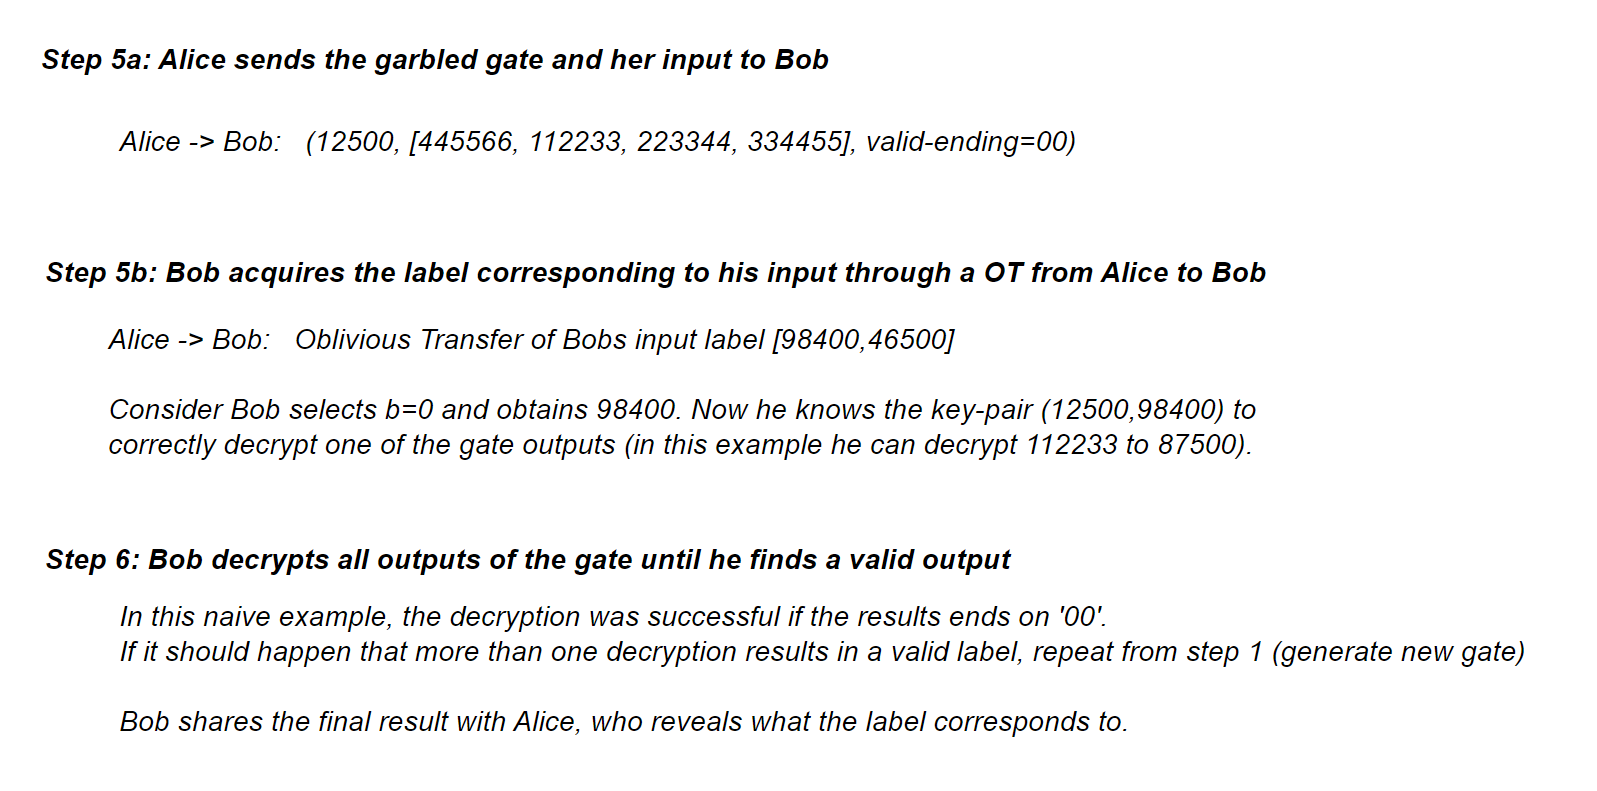

In [ ]:
## visualize the procedure with some images...
count_2 = 0
previousImg_2 = Button(description="previous")
nextImg_2 = Button(description="next")
previousImg_2.on_click(lambda _: display_next_2(-1))
nextImg_2.on_click(lambda _: display_next_2(+1))

def display_next_2(i):
    global count_2
    count_2 = (count_2 + i) % len(img3s)
    clear_output(wait=True)
    display(Image(filename=img3s[count_2]))
    
display(HBox([previousImg_2,nextImg_2]))
clear_output(wait=True)
display(Image(filename=img3s[count_2]))

Here, it seems that we can use pretty much any symmetric encryption as long as we can recognize that a decryption was successful.

We could encript twice:
- $\textrm{Enc}_{k_1,k_2}(m) = \textrm{Enc}_{k_1}(\textrm{Enc}_{k_2}(m))$

Or we could use a hash function ($h$) of both combined keys ($\oplus$), e.g. hash value for the XOR of both keys / concatination of both keys...:
- $\textrm{Enc}_{k_1,k_2}(m) = \textrm{Enc}_{h(k_1 \oplus k_2)}(m))$

Or probably much more...

#### 4.2 A simple symmetric encryption which we will use for this example

We could already see that we require the ability to compute garbled AND and XOR gates.

While one would practically use something like AES, we can just make up a simple encyption for this example, where $\oplus$ corresponds to a binary XOR operation, $\sim$ corresponds to the byte-concatination of both keys, assume $m$ is a 4-byte integer:

\begin{equation}
\textrm{Enc}_{k_1,k_2}(m) = m \oplus (\textrm{SHA256}(k_1 \sim k_2) \textrm{ mod }  2^{32} )
\end{equation}
- we concatinate both keys to obtain the *primary key*: $k_1 \sim k_2$
- we use the sha256 hash of the primary key $\textrm{ mod }  2^{32}$ to obtain a 4-byte *secondary key*
- we encrypt the message $m$ using an XOR with the secondary key
- (think of the secondary key as _simple one-time pad_: each entry of all truth-tables will have a unique one-time pad)

The decryption function would be identical to the encryption function:
\begin{equation}
    \textrm{Dec}_{k_1,k_2}(m) = \textrm{Enc}_{k_1,k_2}(m)
\end{equation}

With the small parameters of the RSA key from above, we can actually only send 17-bit labels - but lets pretend it was 32-bit for now. Practically, we would of course like to increase this to 256-bit keys and use a real encryption scheme, which would require the use of proper cryptographic libraries rather than a naive python impelmentation for both, the encryption and oblivious transfer.

In [ ]:
from hashlib import sha256                           # hashlib library comes with python
hashkeys = lambda k1,k2: int.from_bytes(sha256((k1 ^ k2).to_bytes(4, byteorder='little')).digest(),byteorder='little')

def EncryptDecrypt(m,k1,k2):
    assert m < 2**32 and k1 < 2**32 and k2 < 2**32 
    return m ^ ((hashkeys(k1,k2)) % (2**32))         # a simple and naive encryption

# short test
m, k1, k2 = 153800,13900,97600
print('Encryption/Decryption working: ', m == EncryptDecrypt(EncryptDecrypt(m,k1, k2),k1, k2))

Encryption/Decryption working:  True


#### 4.3 Implementation of garbled circuit module (recursive module from above) -  Alice

In [ ]:
###################################### GARBLED CIRCUIT IMPLEMENTATION #########################################

### circuit takes 1 bit and adds it to n bit number
from random import shuffle, choices
# let's use only values 1-9 for the label to ensure it will be a 5 digit
random_4 = lambda: int(''.join(map(str,choices(range(1,10),k=2)))) # 2 random integers as label - practically of course too little 
trailing = lambda: int(''.join(map(str,choices(range(10),k=3))))   # 3 random integers as trailing to recognize valid decryption

ANDtable = {(0,0):0, (0,1):0, (1,0):0, (1,1):1}
XORtable = {(0,0):0, (0,1):1, (1,0):1, (1,1):0}

class GarbledGate:
    # truthtable is a dictionary of form {(x,y): z}
    # the input mappings can be provided optinally, which is needed for chaining gates
    def __init__(self, truthtable, x_dict=None, y_dict=None): 
        self.truthtable = truthtable
        self.trailing = trailing()
        # generate random value mappings
        self.x_dict = {x:random_4()*1000 + trailing() for x in set([k[0] for k in truthtable.keys()])} if x_dict == None else x_dict
        self.y_dict = {y:random_4()*1000 + trailing() for y in set([k[1] for k in truthtable.keys()])} if x_dict == None else y_dict
        while True: # re-generate ouput labels, until they differ from each other
            self.z_dict = {z:random_4()*1000 + self.trailing for z in set(truthtable.values())} # only the ouput must have a known trailing, the inputs don't matter
            if len(set(self.z_dict.values())) == 2:
                break  
        
    def get_gate(self):
        encryptedGate = [EncryptDecrypt(self.z_dict[z],self.x_dict[x],self.y_dict[y]) for ((x,y),z) in self.truthtable.items()]
        shuffle(encryptedGate)  # shuffle is in place
        return (encryptedGate, self.trailing) # return gate list + trailing
    

class RecursiveGarbledCircuitModule:
    def __init__(self, depth, n_dicts):            # n_dicts is a dict mapping for all input bits of n
        assert len(n_dicts) == ceil(log2(depth))
        self.depth = depth
        self.n_dicts = n_dicts
        self.inputAnd = GarbledGate(ANDtable)
        self.all_gates = [self.inputAnd]
        self.output_dicts = []
        second_input_dict = self.inputAnd.z_dict
        ANDgate = self.inputAnd
        for ni_dict in n_dicts:
            # generate half-adder with correct input/output label mappings
            XORgate = GarbledGate(XORtable,ni_dict,second_input_dict)
            ANDgate = GarbledGate(ANDtable,ni_dict,second_input_dict)
            self.all_gates.append(XORgate)
            self.all_gates.append(ANDgate)
            self.output_dicts.append(XORgate.z_dict)
            second_input_dict = ANDgate.z_dict
        self.output_dicts.append(ANDgate.z_dict)
        self.output_dicts = self.output_dicts[:ceil(log2(depth+1))]   # remove any extra bits of output if not needed

    def AliceLabel(self):
        return self.inputAnd.x_dict
    
    def BobLabel(self):
        return self.inputAnd.y_dict
    
    def outputLabelList(self):
        return self.output_dicts
    
    def garbledGateList(self):
        return [x.get_gate() for x in self.all_gates]

class FullGarbledCircuit:
    def __init__(self,alphabet_size):
        self.alphabet_size = alphabet_size
        self.all_modules = []
        self.AliceLabelList = []
        self.BobLabelList = []
        n_dicts = []
        for d in range(1,alphabet_size+1):
            module = RecursiveGarbledCircuitModule(d, n_dicts)
            self.all_modules.append(module)
            self.AliceLabelList.append(module.AliceLabel())
            self.BobLabelList.append(module.BobLabel())
            n_dicts = module.outputLabelList()
        self.output_dicts = n_dicts
    
    def AliceLabels(self):
        return self.AliceLabelList
    
    def BobLabels(self):
        return self.BobLabelList
    
    def resultLabels(self):
        return self.output_dicts
    
    def getModuleList(self):
        return self.all_modules
    
    def getGarbledGateList(self):
        return [m.garbledGateList() for m in self.all_modules]
    
    def convertResult(self,result):  # 'result' is a list of computed output labels
        # check that result is valid
        if not all([(r in d.values()) for r,d in zip(result,self.output_dicts)]):
            print('Invalid result...')
            return None
        # compute result
        invDict = [{v:k for k,v in d.items()} for d in self.output_dicts]
        binaryResult = [d[x] for x,d in zip(result,invDict)]
        reverseAsString = map(str,reversed(binaryResult))
        reverseAsString = ''.join(reverseAsString)
        return int(reverseAsString,2)

In [ ]:
###################################### GARBLED CIRCUIT SHORT DEMO #########################################
# create garbled circuit
circuit = FullGarbledCircuit(5)
# get output labels
resMap = circuit.resultLabels()
# the result corresponding to 011 (lsb-to-msb) should be equal to 6
#                                                                  0            1            1
print('Implementation working: ', circuit.convertResult([resMap[0][0],resMap[1][1],resMap[2][1]]) == 6)
print('\nExample gabled circuit (gate-lists of depth=2 / three gates):')
_ = [print(g) for g in circuit.getGarbledGateList()[1]]

Implementation working:  True

Example gabled circuit (gate-lists of depth=2 / three gates):
([1793110173, 1802241269, 517861532, 3458057686], 920)
([3113720909, 3990721430, 880868228, 826337524], 213)
([3990618903, 826342261, 880896773, 3113740540], 756)


In [ ]:
###################################### PARALLE OBLIVIOUS TRANSFER #########################################
# M = [(m0,m1), (m0,m1),...]
# B = [b,b,...]
def ParallelObliviousTransfer(M,B,channel,privateKey):
    e,d,N = privateKey
    assert all([(b in [0,1]) for b in B])                # assert b valid
    assert all([(m0 < N and m1 < N) for m0,m1 in M])     # assert m0 % N == m0 and m1 % N == m1 (can be encrypted)
    random = lambda: randint(0,N) # define a random function of arbitrary range
    
    # Step 1: Alice sends two random numbers
    channel.append(('OT A->B s1',[(x0 := random(), x1 := random()) for m in M]))
    
    # step 2: Bob sends v
    XB = [(x0 if b == 0 else x1) for b in B]
    K = [random() for b in B]
    V = [((xb + k**e) % N) for xb,k in zip(XB,K)]
    channel.append(('OT B->A s2',V))
    
    # step 3: Alice sends the shifted messages
    MD = [((m0 + ((v - x0)**d) % N), (m1 + ((v - x1)**d) % N)) for ((m0,m1),v) in zip(M,V)]
    channel.append(('OT A->B s3',MD))
    
    # step 4: Bob computes the result
    MBS = [(m0s if b == 0 else m1s) for ((m0s,m1s),b) in zip(MD,B)]
    MB = [(mbs - k) % N for mbs,k in zip(MBS,K)]
    
    return MB

#### 4.4 Implementation evaluatin of garbled circuit modules - Bob

In [ ]:
############################### BOB's GARBLED CIRCUIT EVALUATION FUNCTION ######################################

def evaluate_gate(gate,k1,k2,trailing,verbose=True):
    decrypted = [EncryptDecrypt(x,k1,k2) for x in gate]
    # a valid label in this case consists of 5 digits, ending on the trailing
    if sum([x%1000 == trailing and len(str(x)) == 5 for x in decrypted]) != 1:   # check that only one decrypted output is a valid label (ending on three zeros)
        if verbose:
            print('Ambiguos gate result: ',decrypted,trailing)
        return None
    else:
        return list(filter(lambda x: x%1000 == trailing and len(str(x)) == 5, decrypted))[0]  # return the unique valid label as garble result

def evaluate_circuit(garbledGates,AliceInputLabels,BobInputLabels,verbose=False):
    # reversing the labels so we can obtain the next input using pop
    AliceInputLabels_rev = list(reversed(AliceInputLabels))
    BobInputLabels_rev = list(reversed(BobInputLabels))
    
    # 'd' keeps track of the depth of our current module
    ns = []
    for d in range(1,len(garbledGates)+1):
        module = garbledGates[d-1]
        # the first gate is always the and gate, which consumes an input from alice and Bob
        gate,trailing = module[0]
        andRes = evaluate_gate(gate,AliceInputLabels_rev.pop(),BobInputLabels_rev.pop(),trailing)
        if andRes == None:
            return None
        # iterate over half-adders
        res = []
        assert len(ns)*2 == len(module)-1 or print(ns,module,len(ns)*2,len(module))
        for ((xorG,trailing1),(andG,trailing2),ni) in zip(module[1::2],module[2::2],ns):
            res.append(evaluate_gate(xorG,ni,andRes,trailing1))
            andRes = evaluate_gate(andG,ni,andRes,trailing2)          # new and result for next half-adder
            if andRes == None or res[-1] == None:
                return None
        res.append(andRes)
        ns = res[:ceil(log2(d+1))] # for next module, the current result will be the input
        if verbose:
            print(f'Circuit output at depth={d}: \t{ns}')
    return ns

### 4.5 Full example run

In [ ]:
############################### FULL DEMOSTRATION ######################################


# pre-processing of Alice and Bob (word to circuit input dictionary)
from string import ascii_lowercase                   # string library comes with python

def simulateComputation(alphabet, AliceWord, BobWord, channel, verbose=False, circuitCheck=lambda x: True):
    assert all([(c in alphabet) for c in AliceWord]) # check that Alice word is within the alphabet 
    assert all([(c in alphabet) for c in BobWord])   # check that Bob word is within the alphabet 

    ## Both parties perform preprocessin to input representation
    AliceInput = [(c, 1 if (c in AliceWord) else 0) for c in alphabet]  # generate Alice circuit input
    BobInput   = [(c, 1 if (c in BobWord)   else 0) for c in alphabet]  # generate Bob circuit input
    
    while True: # in case the computation of a gate fails - repeat
        ## Alice constructs garbled circuit and sends the garbled gates to Bob
        while True:
            circuit = FullGarbledCircuit(len(alphabet))
            if circuitCheck(circuit):                     # in experiment 2 (Section 5.2) we will add a check here
                break
        BobsLabels = circuit.BobLabels()
        AliceInputLabels = [dict_mapping[x] for ((letter,x),dict_mapping) in zip(AliceInput,circuit.AliceLabels())]
        channel.append(('A -> B: garbled circuit', (garbledGates := circuit.getGarbledGateList(), AliceInputLabels)))

        ## Bob obtains its input via OTs, evaluates the circuit and sends the result to Alice
        BobInputLabels = ParallelObliviousTransfer([(d[0],d[1]) for d in BobsLabels],[x[1] for x in BobInput],channel,AlicePrivateKey)  # using private key since Alice is the sender / Bob replies according to 'x'
        #for ((letter,x),dict_mapping) in zip(BobInput,BobsLabels):
        #    BobInputLabels.append(ObliviousTransfer(dict_mapping[0],dict_mapping[1],x,channel,AlicePrivateKey))   
        
        garbledResult = evaluate_circuit(garbledGates,AliceInputLabels,BobInputLabels,verbose=verbose)
        if garbledResult == None:
            print('Ambiguous gate encountered. Computation will be repeated with a new circuit...')
        else:
            channel.append(('B -> A: garbled result', garbledResult))

            ## Alice reveals final result from output labels
            result = circuit.convertResult(garbledResult)
            channel.append(('A -> B: converted result', result))
            
            if verbose:
                print("\n> Bob's final result: ", garbledResult)
                print('> Alice reveals label meaning: \t\t', result)
                print('> The correct result would have been:\t', IntersectionCount_v2(AliceInput,BobInput,0))
            break


alphabet  = list(ascii_lowercase) + [' ']            # let's consider lower case letters and empty spaces
AliceWord = 'red tulip'                              # pick word for Alice
BobWord   = 'yellow tulip'                           # pick word for Bob
channel = []
simulateComputation(alphabet, AliceWord, BobWord, channel, verbose=True)

Circuit output at depth=1: 	[89138]
Circuit output at depth=2: 	[15279, 38174]
Circuit output at depth=3: 	[42036, 17572]
Circuit output at depth=4: 	[53563, 66679, 58472]
Circuit output at depth=5: 	[39339, 25009, 47575]
Circuit output at depth=6: 	[57751, 83970, 89759]
Circuit output at depth=7: 	[81870, 56938, 79891]
Circuit output at depth=8: 	[67303, 28389, 24010, 41837]
Circuit output at depth=9: 	[88327, 29438, 68554, 45657]
Circuit output at depth=10: 	[75464, 65984, 65385, 41999]
Circuit output at depth=11: 	[74597, 91564, 94445, 58274]
Circuit output at depth=12: 	[37208, 22269, 34796, 75537]
Circuit output at depth=13: 	[92566, 45064, 32018, 29503]
Circuit output at depth=14: 	[51035, 45333, 73191, 87858]
Circuit output at depth=15: 	[81263, 41879, 57748, 51098]
Circuit output at depth=16: 	[12609, 42655, 17850, 41511, 22230]
Circuit output at depth=17: 	[95250, 32395, 57087, 16529, 32857]
Circuit output at depth=18: 	[64446, 62538, 36220, 79655, 29483]
Circuit output at dep

In [ ]:
print('To trace the computation, these are the corresponding labels for each depth from Alice:')
for d,m in enumerate(circuit.getModuleList()):
    print(f'> Correct labels at depth={d+1}:\n  {m.outputLabelList()}')

To trace the computation, these are the corresponding labels for each depth from Alice:
> Correct labels at depth=1:
  [{0: 86970, 1: 48970}]
> Correct labels at depth=2:
  [{0: 87213, 1: 55213}, {0: 83756, 1: 73756}]
> Correct labels at depth=3:
  [{0: 96000, 1: 52000}, {0: 54616, 1: 62616}]
> Correct labels at depth=4:
  [{0: 18908, 1: 12908}, {0: 78533, 1: 23533}, {0: 82906, 1: 88906}]
> Correct labels at depth=5:
  [{0: 34638, 1: 74638}, {0: 74684, 1: 68684}, {0: 67375, 1: 14375}]


In [ ]:
print(f'And of course we can inspect the channel. These are the last 2 messages:\n{channel[-2:]}', )

And of course we can inspect the channel. These are the last 2 messages:
[('B -> A: garbled result', [51481, 44350, 13178, 61707, 34807]), ('A -> B: converted result', 7)]


___________________________________________________________
### 5. Random simulation experiments

### 5.1 Experiment 1

In [ ]:
############################ GENERATING A RANDOM DATA SET FROM THE SIMULATION ###################################

from string import printable
experimentRepetitions = 3
packetload = 65515
frameload  =  1460
wordsize   =   256

# let's define a function to flatten an arbitrarily nested list, so we can easily analyse the recorded channel
def flatten(l):
    match(l):
        case int(l):           return [l]
        case list(l)|tuple(l): return sum([flatten(x) for x in l], [])
    

# let's generate some data for an analysis
AnalysisResult = {} # key=alphabet size, value=dictionary of results
for alpha in range(1,len(printable)):
    clear_output(wait=True)
    print(f'progress state (alphabet size) {alpha+1} of {len(printable)} (text showing up below indicates Bob hit an ambiguos gate)')
    AnalysisResult[alpha] = {'#messages':[],'#packets':[],'#frames':[],'#data [kByte]':[]}
    for x in range(experimentRepetitions): # repeat experiment multiple times (ambigous gates possible -> rquires repeat)
        # experiment simulation
        alphabet  = printable[:alpha]                             # let's get an alphabet of the desired size
        AliceWord = choices(alphabet,k=randint(0,len(alphabet)))  # generate a random word
        BobWord   = choices(alphabet,k=randint(0,len(alphabet)))  # generate a random word
        channel = []
        simulateComputation(alphabet, AliceWord, BobWord, channel, verbose=False)
        
        # experiment evaluation
        words = [len(flatten(x[1])) for x in channel] # how many words were in each message?
        AnalysisResult[alpha]['#messages'].append(len(words))
        AnalysisResult[alpha]['#packets'].append(sum([ceil(ceil(x*wordsize/8)/packetload) for x in words]))
        AnalysisResult[alpha]['#frames'].append(sum([ceil(ceil(x*wordsize/8)/frameload) for x in words]))
        AnalysisResult[alpha]['#data [kByte]'].append(ceil(sum(words)*wordsize/8)/1000)

result = DataFrame(AnalysisResult)

progress state (alphabet size) 100 of 100 (text showing up below indicates Bob hit an ambiguos gate)
Ambiguos gate result:  [52845, 2037827821, 2037827821, 52845] 845
Ambiguos gate result:  [58004, 2037809796, 2037809796, 33004] 4
Ambiguous gate encountered. Computation will be repeated with a new circuit...


Simulation result parameters:
	- 3 experiment repetitions
	- assumed label/key size of 256 bit
	- assumed maximal packet size 65515 byte
	- assumed maximal fragment size 1460 byte


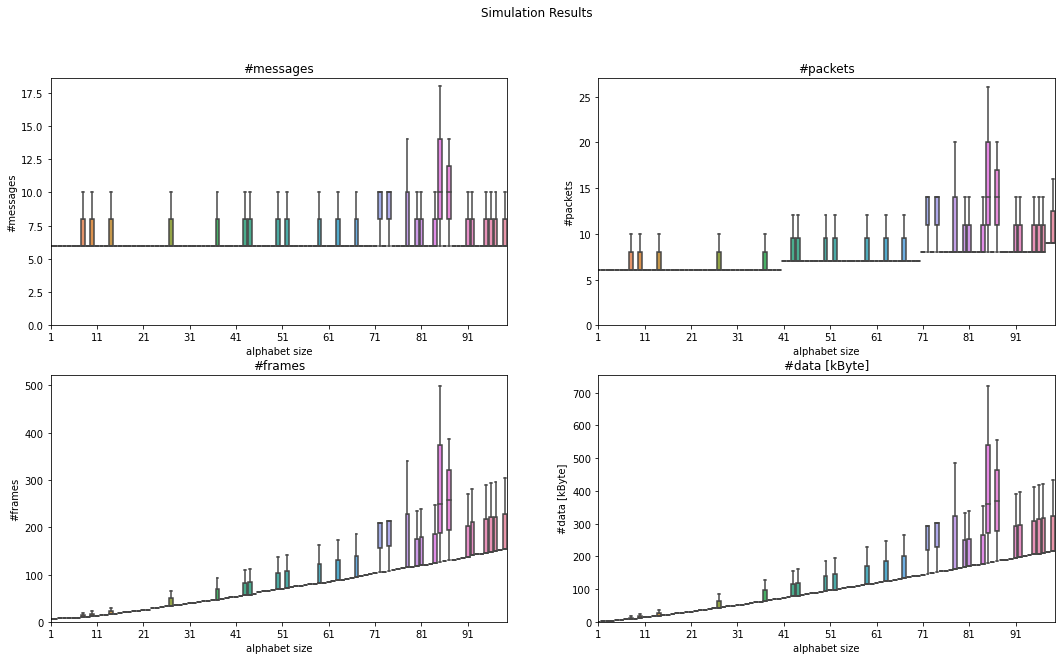

In [ ]:
print(f'Simulation result parameters:\n\t- {experimentRepetitions} experiment repetitions\n\t- assumed label/key size of {wordsize} bit\n\t- assumed maximal packet size {packetload} byte\n\t- assumed maximal fragment size {frameload} byte')
fig, axes = plt.subplots(2, 2,figsize=(18, 10))
fig.suptitle('Simulation Results')
for x,y,res in ([(0,0,'#messages'),(0,1,'#packets'),(1,0,'#frames'),(1,1,'#data [kByte]')]):
    boxplot(ax=axes[x,y],data=DataFrame({alpha: d[res]for (alpha,d) in AnalysisResult.items()}))
    axes[x,y].set_ylim(0,)
    axes[x,y].set_xlim(0,)
    axes[x,y].set_xlabel('alphabet size')
    axes[x,y].set_ylabel(res)
    axes[x,y].set_title(res)
    axes[x,y].set_xticks(range(0,99,10))
plt.show()

**<center>Brief analysis discussion</center>**
<center>While the minimum values match our theoretical analysis, we can see a deviation of the average and maximum due to the issue of ambigous gates (gate decryption had no unique valid label) in our naive implementation which requires to abort the circuit and restart with a new one.</center>


<center>We can see how often an ambiguos gate has been encountered in the results, since it causes a factor for the expected performance. For each alphabet size, $\max = n \cdot \min$, where $n$ was the number of required repeitions for one of the three experiments.</center>

#### Experiment 1 result

The occurence of ambiguos gates is problematic for two resons:
1. When Bob encounters an ambiguos gate, the protocol was repeated from the beginning. This significantly increases the required communication and transmission size.
2. When Bob aborts the computation due to encountering an ambiguos gate, it leaks information about the computation state to Alice and therefore also leaks information about the circuit input. 

To avoid this, Alice has to check that the generated circuit does not contain any ambiguos gates before sending it to Bob.

### 5.2 Experiment 2

##### We modify experiment 1 such that Alice now checks if her circuit contains any ambiguos gates and corrects the circuit before sending it.

In [ ]:
############################ GENERATING A RANDOM DATA SET FROM THE SIMULATION ###################################

from string import printable
experimentRepetitions = 3
packetload = 65515
frameload  =  1460
wordsize   =   256

# check that there are no ambiguos gates
def circuitCheck(circuit):
    for module in circuit.getModuleList():
        for gate in module.all_gates:
            encryptedGate, trailing = gate.get_gate()
            for x in gate.x_dict.values():
                for y in gate.y_dict.values():
                    if evaluate_gate(encryptedGate,x,y,trailing,verbose=True) == None:
                        return False # ambiguos gate found
    return True


# let's generate some data for an analysis
AnalysisResult = {} # key=alphabet size, value=dictionary of results
for alpha in range(1,len(printable)):
    clear_output(wait=True)
    print(f'progress state (alphabet size) {alpha+1} of {len(printable)} (text showing up below indicates Alice found an ambiguos gate)')
    AnalysisResult[alpha] = {'#messages':[],'#packets':[],'#frames':[],'#data [kByte]':[]}
    for x in range(experimentRepetitions): # repeat experiment multiple times (ambigous gates possible -> rquires repeat)
        # experiment simulation
        alphabet  = printable[:alpha]                             # let's get an alphabet of the desired size
        AliceWord = choices(alphabet,k=randint(0,len(alphabet)))  # generate a random word
        BobWord   = choices(alphabet,k=randint(0,len(alphabet)))  # generate a random word
        channel = []
        simulateComputation(alphabet, AliceWord, BobWord, channel, verbose=False,circuitCheck=circuitCheck)
        
        # experiment evaluation
        words = [len(flatten(x[1])) for x in channel] # how many words were in each message?
        AnalysisResult[alpha]['#messages'].append(len(words))
        AnalysisResult[alpha]['#packets'].append(sum([ceil(ceil(x*wordsize/8)/packetload) for x in words]))
        AnalysisResult[alpha]['#frames'].append(sum([ceil(ceil(x*wordsize/8)/frameload) for x in words]))
        AnalysisResult[alpha]['#data [kByte]'].append(ceil(sum(words)*wordsize/8)/1000)

result = DataFrame(AnalysisResult)

progress state (alphabet size) 100 of 100 (text showing up below indicates Alice found an ambiguos gate)


Simulation result parameters:
	- 3 experiment repetitions
	- assumed label/key size of 256 bit
	- assumed maximal packet size 65515 byte
	- assumed maximal fragment size 1460 byte


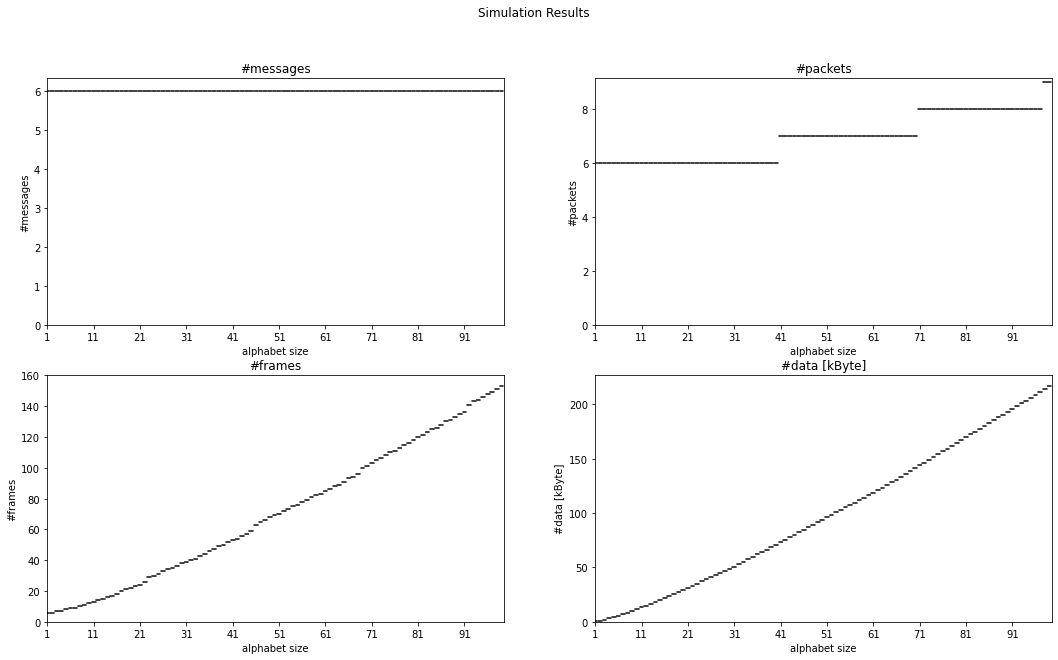

In [ ]:
print(f'Simulation result parameters:\n\t- {experimentRepetitions} experiment repetitions\n\t- assumed label/key size of {wordsize} bit\n\t- assumed maximal packet size {packetload} byte\n\t- assumed maximal fragment size {frameload} byte')
fig, axes = plt.subplots(2, 2,figsize=(18, 10))
fig.suptitle('Simulation Results')
for x,y,res in ([(0,0,'#messages'),(0,1,'#packets'),(1,0,'#frames'),(1,1,'#data [kByte]')]):
    boxplot(ax=axes[x,y],data=DataFrame({alpha: d[res]for (alpha,d) in AnalysisResult.items()}))
    axes[x,y].set_ylim(0,)
    axes[x,y].set_xlim(0,)
    axes[x,y].set_xlabel('alphabet size')
    axes[x,y].set_ylabel(res)
    axes[x,y].set_title(res)
    axes[x,y].set_xticks(range(0,99,10))
plt.show()

**<center>Brief analysis discussion</center>**
<center>The experimental results match the theoretical once. Alice ensured that her circuits did not contain any ambiguos gates such that no information is leacked.</center>

__________________________________
### 6.  Discussion and Conclusion

- We found, implemented and analyzed one possible solution to the set-intersection problem using garbled circuits
- The garbled circuit is indpendent of the string lengths from Alice and Bob.
- The circuit complexity and total tranmission data scales with the alphabet and key size like shown above (theoretical analysis section 3.2).
- We encountered and demonstrated an issue of ambiguos gates in our naive implementation (section 5), experimentally demonstrated its impact and discussed that this would leak information from Bob to Alice (experiment 1). Therefore, we also demonstrated a possible solution with experiment 2.

#### Further improvements and optimizations
- The _free XOR optimization_ could be used to significanlty reduce the requires number of gates
- The used parameters in this examples are too small, however, this allowed for a naive implementation without cryptographic libraries to understand the process in detail.

#### Our final questions in preparation for the next module:
- How do garbled circuits and homomorphic encryption relate to each other? Do they make different assumptions? 
- Can garbled circuits and homomorphic encryption be combined?
- *For example:* instead of using random labels, could Alice use a randomized homomorphic encryption such as the paillier cryptosystem to assign labels? Would this reduce the complexity of the problem down to $\alpha$ gates (instead of $\alpha + 2\cdot \sum_{d=1}^{\alpha} \lceil \log_2(d) \rceil$ gates right now)?